In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import sys

In [2]:
home = pathlib.Path.home()
path = str(pathlib.Path(home, 'DOSY'))
sys.path.insert(1, path)

In [3]:
from src.mixture_fit import gen_data, fits, sum_exp_curv
from src.data_loading import load_data
from src.optimal_number import AIC_analysis, BIC_analysis, chi2_analysis

In [4]:
seed = 50000
n = 1024
sigma = 5e-5

Критические случаи, когда может быть сложно различить экспоненты:

- близкие показатели экспонент

- малая весовая доля одной из экспонент по отношению к другим долям

За основу возьмём экспоненту с параметрами (0.1, 1), будем докидывать к ней экспоненты с параметрами из массивов W и D.

Качество оценки будем смотреть по метрикам AIC и BIC

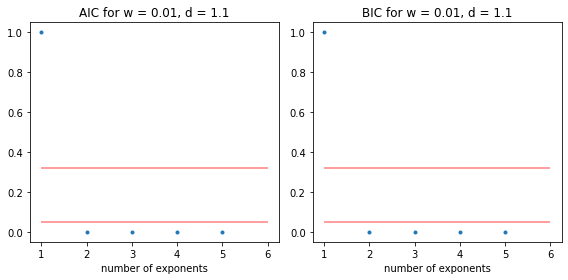

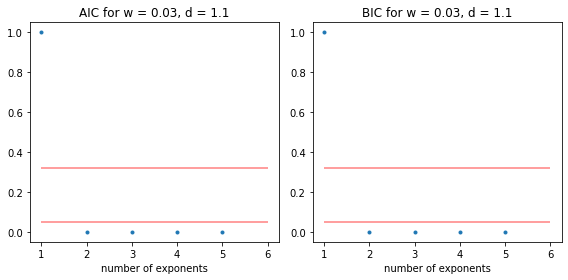

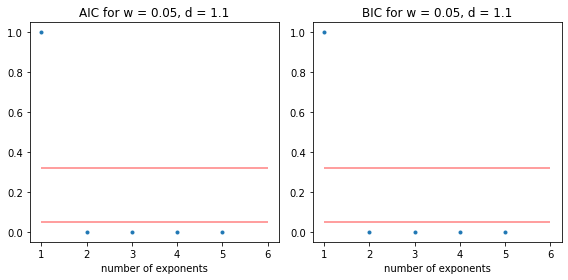

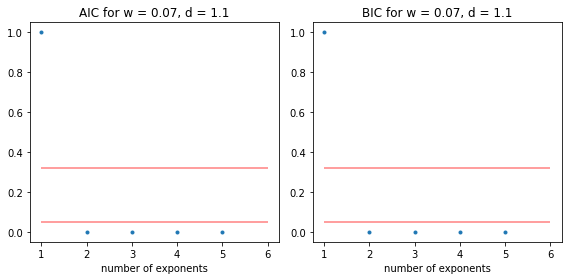

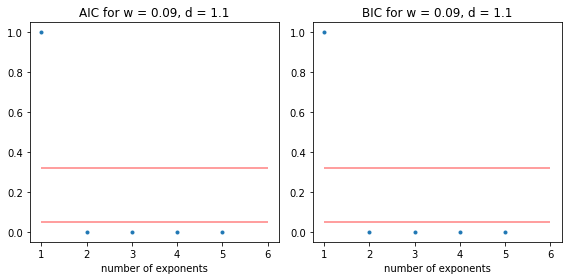

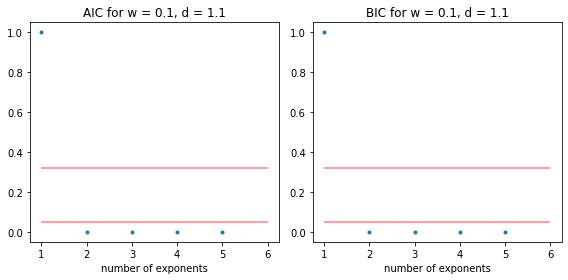

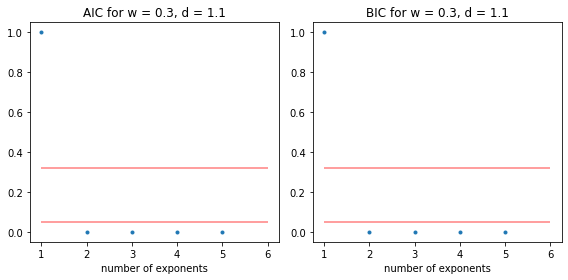

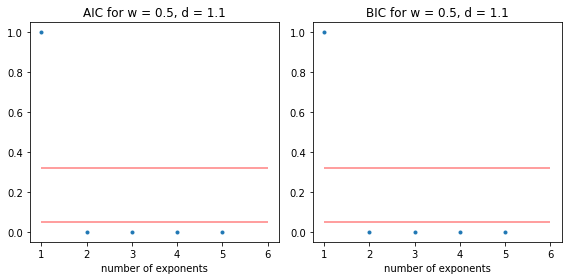

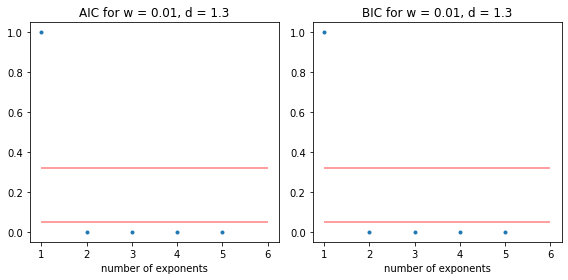

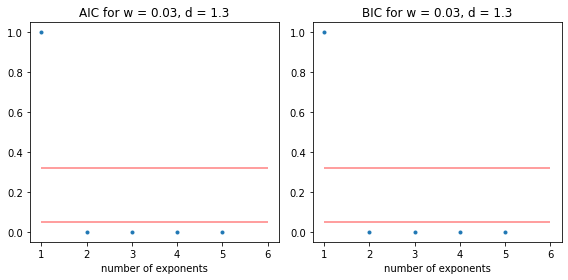

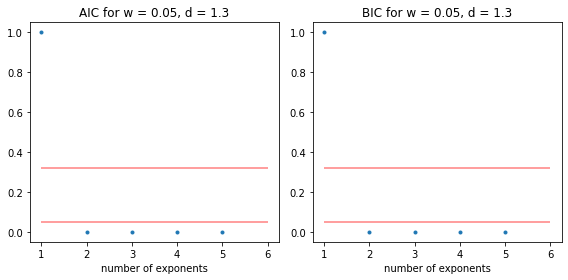

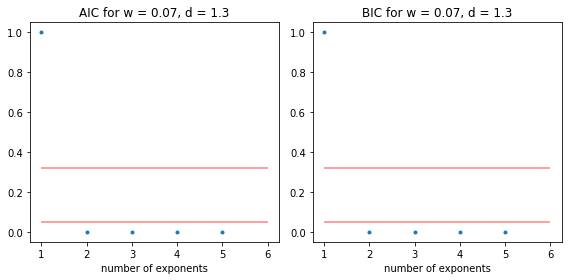

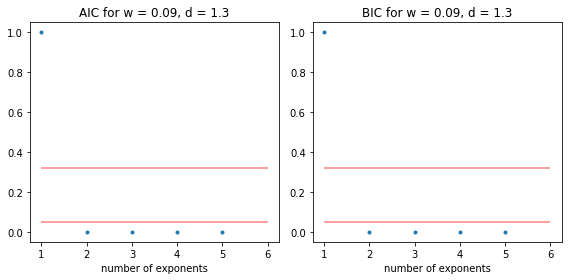

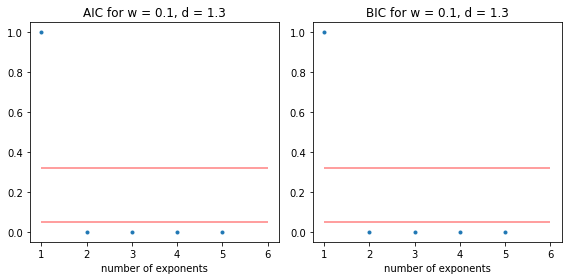

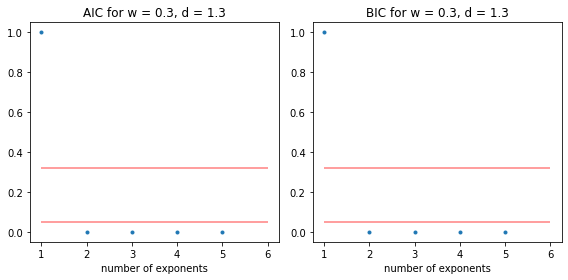

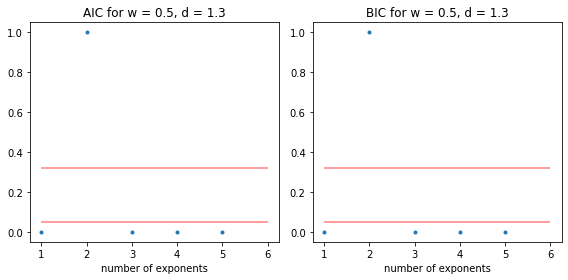

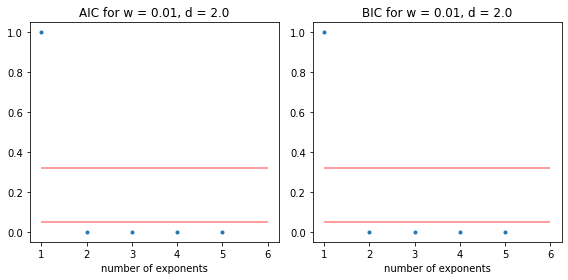

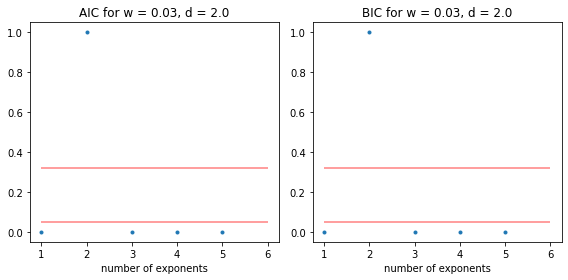

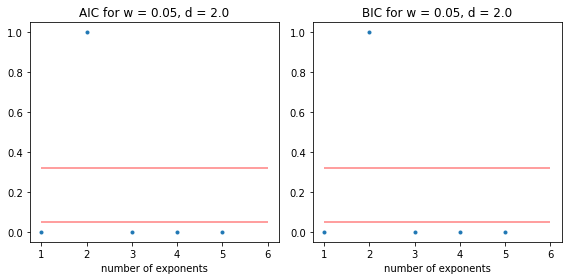

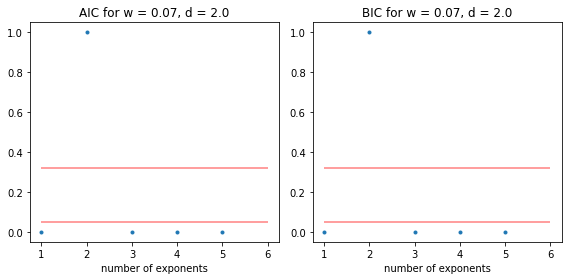

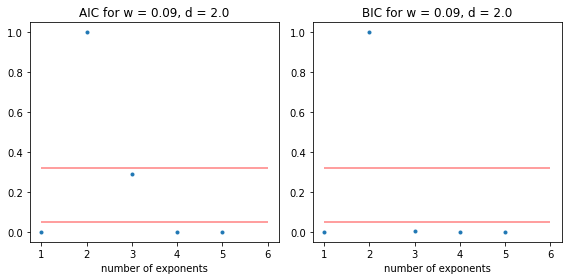

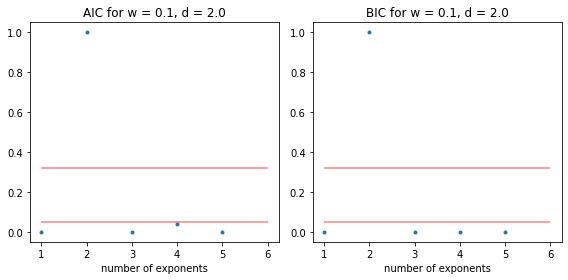

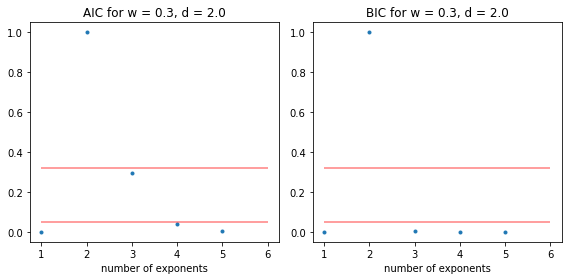

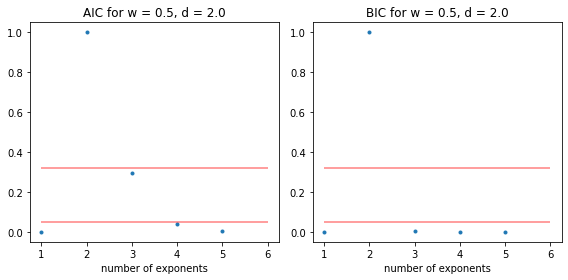

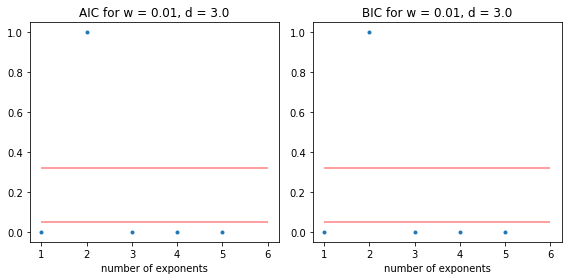

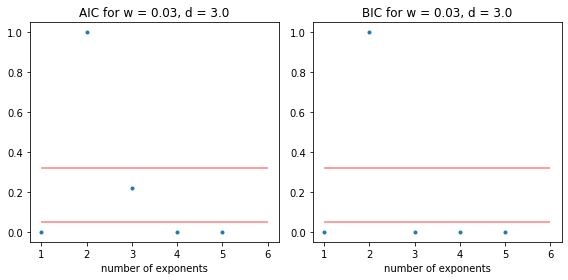

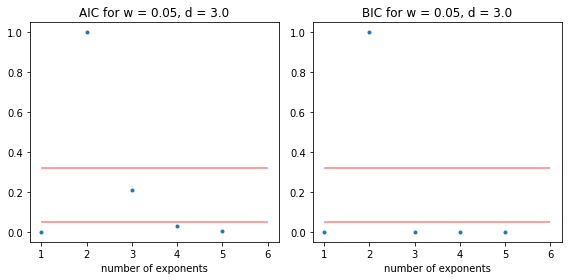

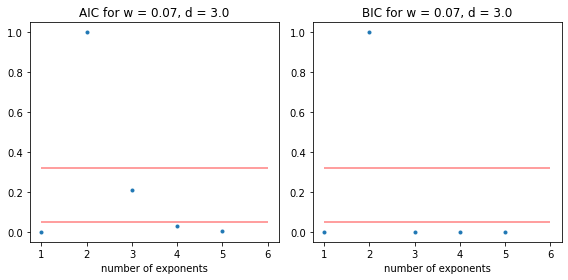

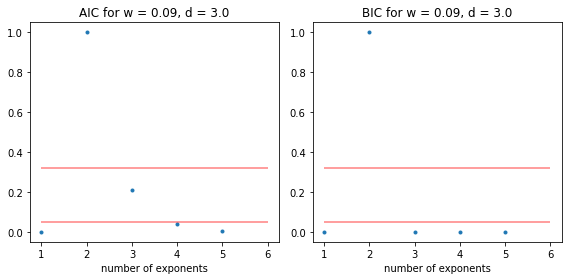

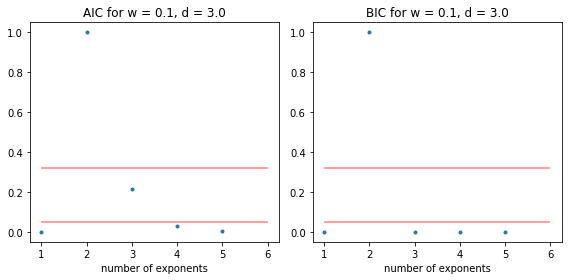

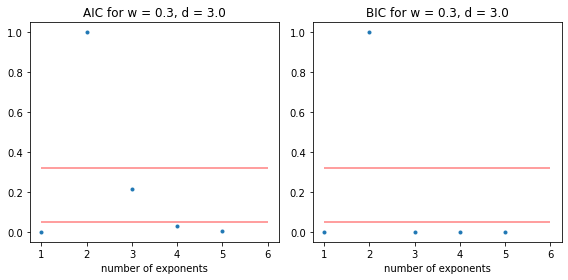

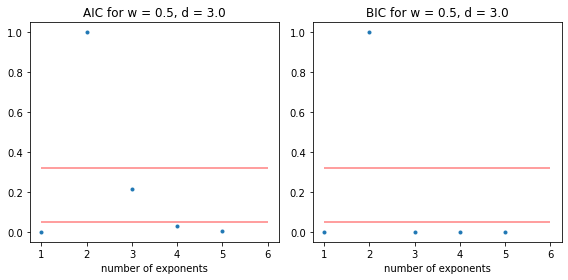

In [66]:
W = np.append(np.arange(0.01, 0.1, 0.02), np.arange(0.1, 0.6, 0.2))
D = np.append(np.arange(1.1, 1.5, 0.2), np.arange(2, 4, 1))

def print_2d(arr):
    for a in arr:
        print()
        print(*a)
        print()

for d in D:
    for w in W:
        x, y = gen_data(seed, np.array([0.1, 1, w, d]), n, sigma)

        params_est, s = fits(x, y, n_max = 5)
        plt.figure(figsize=(8, 4))

        plt.subplot(1, 2, 1)
        m, aics, aic_probs = AIC_analysis(x, y, params_est, s)
        plt.scatter(range(1, len(aics)+1), aic_probs, marker='.')
        plt.hlines(0.32, 1, len(aics) + 1, 'r', alpha=0.5)
        plt.hlines(0.05, 1, len(aics) + 1, 'r', alpha=0.5)
        plt.xlabel('number of exponents')
        plt.title("AIC for w = {}, d = {}".format(round(w, 2), round(d, 2)))


        plt.subplot(1, 2, 2)
        m, bics, bic_probs = BIC_analysis(x, y, params_est, s)
        plt.scatter(range(1, len(bics)+1), bic_probs, marker='.')
        plt.hlines(0.32, 1, len(bics) + 1, 'r', alpha=0.5)
        plt.hlines(0.05, 1, len(bics) + 1, 'r', alpha=0.5)
        plt.xlabel('number of exponents')
        plt.title("BIC for w = {}, d = {}".format(round(w, 2), round(d, 2)))

        plt.tight_layout()

        plt.show()

По графикам в целом можно уловить какие-то тенденции, но нагляднее будет следующий подход

Для случая двух экспонент и различных стандартных отклонений построим двумерное множество в координатах (w2/w1, D2/D1), которое будет содержать только те точки, в которых метрики AIC, BIC считают, что экспонент две


Точки, для которых ((exp(dAIC) > 0.32) or (exp(dBIC) > 0.32) для 2-ух экспонент) and ((exp(dAIC) < 0.32) and (exp(dBIC) < 0.32) для одной и трёх экспонент) покрасим в синий цвет

Также по необходимости можно расширить множество и учитывать в том числе те точки, в которых выполняется только первое условие

In [24]:
W = np.arange(0.01, 1.0, 0.01)
D = np.arange(1.1, 2.0, 0.1)


def pred2(aic_p, bic_p):
    a1, a2, a3 = aic_p
    b1, b2, b3 = bic_p

    return (a2 > 0.32 or b2 > 0.32) and (a1 < 0.32 and b1 < 0.32) and (a3 < 0.32 and b3 < 0.32)

DB = []
WB = []
#
# DR = []
# WR = []


for d in D:
    for w in W:
        x, y = gen_data(seed, np.array([0.1, 1, w, d]), n, sigma)

        params_est, s = fits(x, y, n_min=1, n_max = 3)

        m, aics, aic_probs = AIC_analysis(x, y, params_est, s)
        m, bics, bic_probs = BIC_analysis(x, y, params_est, s)

        if pred2(aic_probs, bic_probs):
            WB.append(w / 0.1)
            DB.append(d)

Text(0.5, 1.0, 'Множество, в котором две экспоненты определяются верно для $\\sigma = 5\\cdot 10^{-4}$')

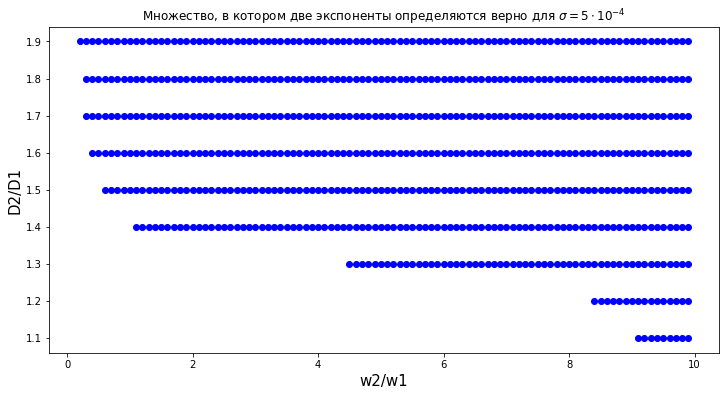

In [28]:
plt.figure(figsize=(12, 6))
plt.scatter(WB, DB, color="blue")
plt.xlabel("w2/w1", fontsize=15)
plt.ylabel("D2/D1", fontsize=15)
plt.title("Множество, в котором две экспоненты определяются верно для $\sigma = 5\cdot 10^{-4}$")

Видно, что проблемы происходят, когда показатели экспонент достаточно близки друг к другу и отношение массовых долей достаточно маленькое. При этом видно, что граница области ведет себя как $\frac{w_1 D_1}{w_2 D_2}$.

Так как оценка качественная, считаю достаточным провести кривую, ограничивающую область снизу "на глаз".

Text(0.5, 1.0, 'Множество, в котором две экспоненты определяются верно для $\\sigma = 5\\cdot 10^{-4}$')

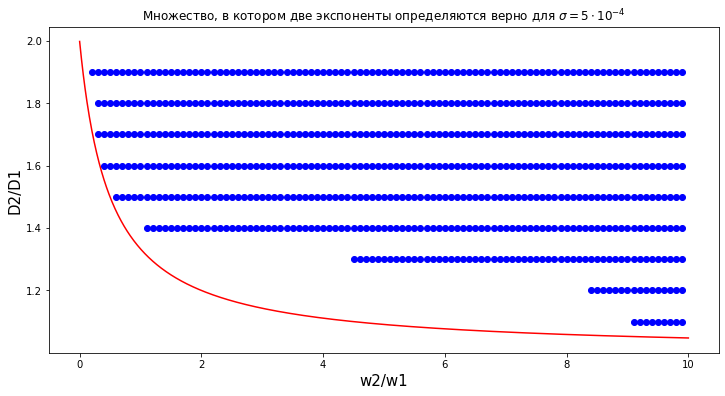

In [65]:
x = np.linspace(0.001, 10.0, 1000)

plt.figure(figsize=(12, 6))

plt.plot(x, 1 + 0.5/(x+0.5), color="red")
plt.scatter(WB, DB, color="blue")

plt.xlabel("w2/w1", fontsize=15)
plt.ylabel("D2/D1", fontsize=15)
plt.title("Множество, в котором две экспоненты определяются верно для $\sigma = 5\cdot 10^{-4}$")

Множество можно задать как $G = \{(w_2/w_1, D_2/D_1) : D_2/D_1 > 1 + \frac{0.5}{w_2/w_1 + 0.5} \}$.


Запись можно упростить. Тут скорее иллюстрация того, что можно достаточно просто задать условия, при которых мы будем правильно детектировать две экспоненты, когда их действительно две